In [28]:
import os
import PyPDF2
import fitz
import pandas as pd
import collections
import re

In [29]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [30]:
dir = 'annoted_sustainability_reports/Real_Estate/'

In [31]:
x_label = ["AmericanTowerCorp", "Prologis", "CrownCastle"]

### Extracting Sentences: Refined Version

In [32]:
# this method will return a list of highlighted sentences in each page 
def get_page_highlights_coord(annot):
    page_highlights_coord = []
    while annot:
        if annot.type[0] == 8:
            all_coordinates = annot.vertices
            try:
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    page_highlights_coord.append(highlight_coord)
                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        page_highlights_coord.append(coord)
            except:
                print("NoneType found")
        annot = annot.next
    return page_highlights_coord
        

In [33]:
def get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord):
    page_highlights = collections.defaultdict(list)
    for h in page_highlights_coord:
        test_dict = collections.defaultdict(list) # intialize a dictionary that keeps order and 
        # indication of where the sentence breaks occur
        for w in all_words:
            if (fitz.Rect(w[0:4]).intersects(h)): 
            # find intersections where the original report overlaps with the highlighted sentences
                new_pos = int(str("%02d" % w[5]) + str("%02d" % w[6]) + str("%02d" % w[7])) 
#                 print(new_pos, w[4])
                if new_pos not in repeat_coord:
                    repeat_coord.append(new_pos)
                    if test_pos <  new_pos:
#                         print('less than', test_pos, new_pos, w[4]) 
                        test_pos = new_pos 
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                    else:
#                         print('greater than', test_pos, new_pos, w[4])
                        test_dict = collections.defaultdict(list)
                        test_pos = 0
                        test_dict[new_pos].append(w[4])
                        page_highlights[new_pos].append(test_dict[new_pos][0])
#                         page_highlights.append({new_pos : test_dict[new_pos]})
                else:
                    continue
    return page_highlights
                    

In [34]:
def get_total_highlights_text(total_page_highlights):
    total_page_highlights_text = []
    for i in total_page_highlights:
        highlights = ""
        sorted_dict = sorted(i.items(), key = lambda kv:kv[0], reverse = False)
        for k in sorted_dict:
            highlights += k[1][0] + " "
            
        total_page_highlights_text.append(highlights)
    
    return total_page_highlights_text

In [35]:
def make_text(words):
    """Return textstring output of getText("words").

    Word items are sorted for reading sequence left to right,
    top to bottom.
    """
    line_dict = {}  # key: vertical coordinate, value: list of words
    words.sort(key=lambda w: w[0])  # sort by horizontal coordinate
    for w in words:  # fill the line dictionary
        y1 = round(w[3], 0)  # bottom of a word: don't be too picky!
        word = w[4]  # the text of the word
        line = line_dict.get(y1, [])  # read current line content
        line.append(word)  # append new word
        line_dict[y1] = line  # write back to dict
    lines = list(line_dict.items())
    lines.sort()  # sort vertically
    return "\n".join([" ".join(line[1]) for line in lines])

In [36]:
import pdftotext

In [37]:
# Get ALL SENTENCES using the pdftotext package:

all_result_refined = []
all_comp_refined = []

# running all the files in the industry folder
for file in os.listdir(dir): 

    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)

    with open(f, "rb") as output:
        pdf = pdftotext.PDF(output)

        # Read all the text into one string
        pdftotext_text = " ".join(pdf)
        
    for sent in tokenize.sent_tokenize(pdftotext_text):
        for within_sent in sent.split('\n\n'):
            all_result_refined.append(within_sent)
            all_comp_refined.append(comp_lab[0])


annoted_sustainability_reports/Real_Estate/AmericanTowerCorp_2021_Sustainability_report.pdf
['AmericanTowerCorp']
annoted_sustainability_reports/Real_Estate/Prologis_21to22_ESG_report.pdf
['Prologis']
annoted_sustainability_reports/Real_Estate/CrownCastle_2021_ESG_report.pdf
['CrownCastle']


In [38]:
len(all_result_refined)

6126

In [39]:
for i in range(len(all_result_refined)):
    all_result_refined[i] = re.sub("\n", " ", all_result_refined[i])
    all_result_refined[i] = re.sub("\x0c", "", all_result_refined[i])
    all_result_refined[i] = re.sub("\x07", "", all_result_refined[i])

In [40]:
from random import sample

In [41]:
sample(all_result_refined, 10)

['This topic is relevant to all stakeholder groups.',
 'Environmental Protection During Site Planning and Construction',
 'Quantitative',
 'Our updated (2022) Science Based Target will be to achieve net zero emissions for our operations (Scopes 1 and 2) by 2030 and for our value chain (Scope 3) by 2040.',
 'ABOUT AMERICAN TOWER',
 '2-1 Organizational details',
 'And to wrap up in the best possible way, we closed on the theme of “The Power of Gratitude,” an opportunity to reflect on how giving thanks can help bring more creativity and prosperity to life.',
 'Additional information on our employees can be found in Inspired People.',
 'ENVIRONMENT',
 'SHARED INFRASTRUCTURE MODEL']

In [42]:
# final list of relevant sentences
final_relevant = []   
final_relevant_comp = []

# final list of all sentences 
final_all = []
final_all_comp = []

# running all the files in the industry folder
for file in os.listdir(dir): 
    
    # f = filename + directory
    f = os.path.join(dir, file) 
    print(f)
    
    # comp_lab = to label sentence by companies
    comp_lab = list(filter(lambda x:  x in f, x_label))
    print(comp_lab)
    
    # opening each company report
    doc = fitz.open(f) 
    print(doc)
    
    # store the entire report in this list
    all_result = []
    
    test_pos = 0 # keep track of whether values of coordinates increase or decrease --> 
    #reinitialize if decreases because that means its a new set of sentences (paragraph)
    
    total_page_highlights = [] # use this list to store all the highlighted sentences of each page
    
#     test_final_relevant = [] # use this to test printing relevant sentences by company 

    # iterate each page of the document
    for page in doc:
        
        # extract all the sentences in pdf --> store it in all_result
        all_text = page.get_text()
        all_result.append(all_text)
        
        # extract highlighted sentences coordinates from pdf --> using the get_page_highlights_coord method
        annot = page.first_annot
        page_highlights_coord = get_page_highlights_coord(annot)
        
        # convert the page into text so that it can be compared with highlighted coordinates
        all_words = page.get_text_words('words', sort = True)
#         print(all_words)
        
        # only iterate if highlights were detected
        if len(page_highlights_coord) > 0:
            repeat_coord = []
            # use the get_page_highlights_text to extract coordinates and words into dictionary 
            #(remove duplicated coordinates here as well)
            page_highlights = get_page_highlights_text(page_highlights_coord, all_words, test_pos, repeat_coord)
            total_page_highlights.append(page_highlights)
            
    # use get_total_highlights_text method to sort words by coordinates 
    # [so that we can get a cleaner version of sentences] and extract the final version of relevant sentences        
    total_highlights = get_total_highlights_text(total_page_highlights)
    
    # loop around total_highlights to tokenize sentences (breaking chunks into sentences)
    for i in total_highlights:
        i = re.sub("\xa0", " ", i)
        i = re.sub("\t", " ", i)
        i = re.sub("\r", " ", i)
        i = re.sub("\n", " ", i)
        i = re.sub(" +", " ", i)
#         i = i.strip()
        final_relevant += tokenize.sent_tokenize(i)
        final_relevant_comp += comp_lab * len(tokenize.sent_tokenize(i))
    
    print('>>>>RELEVANT<<<<')
    print(final_relevant)
#         test_final_relevant += tokenize.sent_tokenize(i.replace("\n", " "))

    # loop around all_result to tokenize sentences as well
#     for i in all_result:
#         i = re.sub("\xa0", " ", i)
#         i = re.sub("\t", " ", i)
#         i = re.sub("\r", " ", i)
#         i = re.sub("\n", " ", i)
#         i = re.sub(" +", " ", i)
# #         i = i.strip()
#         final_all += tokenize.sent_tokenize(i)
#         final_all_comp += comp_lab * len(tokenize.sent_tokenize(i))
        
#     print('>>>>ALL<<<<')
#     print(final_all)

    print('>>>>ALL_REFINED<<<<')
    print(all_result_refined)
    
            


annoted_sustainability_reports/Real_Estate/AmericanTowerCorp_2021_Sustainability_report.pdf
['AmericanTowerCorp']
Document('annoted_sustainability_reports/Real_Estate/AmericanTowerCorp_2021_Sustainability_report.pdf')
>>>>RELEVANT<<<<
['American Tower is targeting a 40% reduction in indirect scope 3 value chain GHG emissions by 2035 from a 2019 base year.', 'American Tower is targeting a 40% reduction in absolute scope 1 and 2 GHG emissions by 2035 from a 2019 base year.', 'In 2021, our scope 1 emissions decreased 6.5% to 636,157 MTCO2e and our scope 2 (market-based) emissions decreased 6.6% to 486,410 MTCO2e, compared to our 2019 baseline.', 'Our overall scope 1 and 2 emissions reduction of 6.5%, compared to our 2019 baseline, is driven by several factors, including improving communications site energy efficiency, deploying renewable energy solutions and upgrading on-site energy storage systems.', 'At 99% of the approximately 1,000 newly built sites and nearly 75% of the approximately

>>>>RELEVANT<<<<
['American Tower is targeting a 40% reduction in indirect scope 3 value chain GHG emissions by 2035 from a 2019 base year.', 'American Tower is targeting a 40% reduction in absolute scope 1 and 2 GHG emissions by 2035 from a 2019 base year.', 'In 2021, our scope 1 emissions decreased 6.5% to 636,157 MTCO2e and our scope 2 (market-based) emissions decreased 6.6% to 486,410 MTCO2e, compared to our 2019 baseline.', 'Our overall scope 1 and 2 emissions reduction of 6.5%, compared to our 2019 baseline, is driven by several factors, including improving communications site energy efficiency, deploying renewable energy solutions and upgrading on-site energy storage systems.', 'At 99% of the approximately 1,000 newly built sites and nearly 75% of the approximately 2,100 legacy sites, we have installed solar arrays and lithium-ion batteries (LIBs).', 'Also, where possible, we have accelerated grid connections at newly built sites to utilize Kenyan grid power, which is increasing

### Relevant & All Sentences into a DataFrame

In [43]:
rel_text_df = pd.DataFrame([final_relevant, final_relevant_comp]).transpose().rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,American Tower is targeting a 40% reduction in...,AmericanTowerCorp
1,American Tower is targeting a 40% reduction in...,AmericanTowerCorp
2,"In 2021, our scope 1 emissions decreased 6.5% ...",AmericanTowerCorp
3,Our overall scope 1 and 2 emissions reduction ...,AmericanTowerCorp
4,"At 99% of the approximately 1,000 newly built ...",AmericanTowerCorp


In [44]:
all_text_df = pd.DataFrame([all_result_refined, all_comp_refined]).transpose().rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_df.head()

,all_sentences,company_label
0,2021 Sustainability Report,AmericanTowerCorp
1,2,AmericanTowerCorp
2,ABOUT AMERICAN TOWER,AmericanTowerCorp
3,LETTER FROM OUR PRESIDENT AND CEO,AmericanTowerCorp
4,SUSTAINABILITY AT AMERICAN TOWER,AmericanTowerCorp


### Relevant Sentences Statistics

In [45]:
rel_text_df.groupby('company_label', sort = False).count()

,relevant_sentences
company_label,
AmericanTowerCorp,17
Prologis,25
CrownCastle,4


In [46]:
# Old Version
# rel_text_df.groupby('company_label', sort = False).count()

In [47]:
rel_text_df[rel_text_df.duplicated()]

,relevant_sentences,company_label


In [48]:
all_text_df.groupby('company_label', sort = False).count()

,all_sentences
company_label,
AmericanTowerCorp,3634
Prologis,2098
CrownCastle,394


In [49]:
# Old Version
# all_text_df.groupby('company_label', sort = False).count()

### Getting Sentence Statistics 

In [50]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_df.groupby('company_label', sort = False).count()

In [51]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
AmericanTowerCorp,3634,17,0.467804
Prologis,2098,25,1.191611
CrownCastle,394,4,1.015228


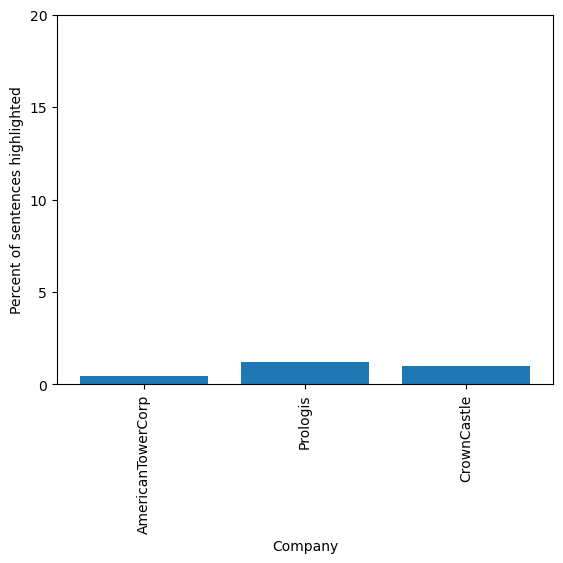

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x_label, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 25, 5))
plt.show()

In [53]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    3.000000
mean     0.891548
std      0.377421
min      0.467804
25%      0.741516
50%      1.015228
75%      1.103420
max      1.191611
dtype: float64

### Exporting and Saving Files 

In [54]:
#storing variable so they can be called between notebooks (for ML and aggregate work later on)

Real_Estate_reltext = rel_text_df
Real_Estate_alltext = all_text_df
Real_Estate_stat = final_text_stat

%store Real_Estate_reltext
%store Real_Estate_alltext
%store Real_Estate_stat

Stored 'Real_Estate_reltext' (DataFrame)
Stored 'Real_Estate_alltext' (DataFrame)
Stored 'Real_Estate_stat' (DataFrame)
